# Wine Quality Prediction Model
## Developed By: Vardhan Chulani, Arndt Selzner, Jingyuan Jiang, and Xi Shi
### December 2023 - Modern Analytics
* Data Source: [Link](https://archive.ics.uci.edu/dataset/186/wine+quality)
* Presentation : [Link](https://docs.google.com/presentation/d/1SjaZZ8TbNBRxMnfrIMgvfpKrcK7QqDbJ/edit?usp=sharing&ouid=108202421410161001456&rtpof=true&sd=true)


Installing necessary packages and importing core functions

In [1]:
pip install ucimlrepo

In [3]:
pip install scipy

In [4]:
pip install xgboost

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import numpy as np
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, median_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
import lightgbm
from ucimlrepo import fetch_ucirepo
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn.functional as F
import torch.optim as optim
from scipy.stats import shapiro
import xgboost as xgb


Importing data from the UC Irvine repository

In [ ]:
wine_quality = fetch_ucirepo(id=186)

features = wine_quality.data.features
targets = wine_quality.data.targets
total_df = wine_quality.data.original

In [ ]:
total_df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


**Performing descriptive analysis**

*   Statistical summary
*   Feature importance

*   Data distribution by feature
*   Data Transformation - Skewness

*   Data Normalization

In [ ]:
total_df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


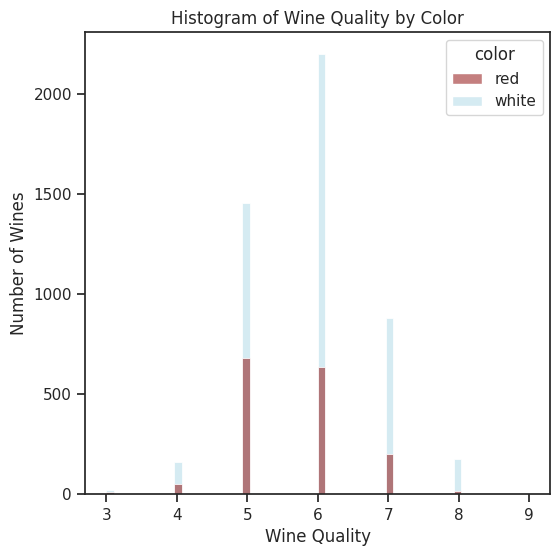

In [ ]:
sns.set(style="ticks")
plt.figure(figsize=(6, 6))
sns.histplot(data=total_df, x='quality', hue='color', palette={'red': 'darkred', 'white': 'lightblue'},)
plt.title('Histogram of Wine Quality by Color')
plt.xlabel('Wine Quality')
plt.ylabel('Number of Wines')
plt.show()

In [ ]:
grouped_by_color = total_df.groupby('color')['quality']

for color, group_data in grouped_by_color:
    print(f"\nStatistics for {color} wines:")
    print(f"Minimum quality: {group_data.min()}")
    print(f"Maximum quality: {group_data.max()}")
    print(f"Median quality: {group_data.median()}")
    print(f"Mean quality: {group_data.mean()}")


Statistics for red wines:
Minimum quality: 3
Maximum quality: 8
Median quality: 6.0
Mean quality: 5.6360225140712945

Statistics for white wines:
Minimum quality: 3
Maximum quality: 9
Median quality: 6.0
Mean quality: 5.87790935075541


In [ ]:
quality_counts = total_df['quality'].value_counts(normalize=True).reset_index()
quality_counts.columns = ['quality', 'percentage']
fig = px.pie(quality_counts, values='percentage', names='quality', title='Distribution of Wine Quality')
fig.update_traces(textinfo='percent+label', pull=[0.1 if i == 0 else 0 for i in range(len(quality_counts))])
fig.update_layout(showlegend=True)
fig.show()

<ipython-input-36-06bf7f83c049>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



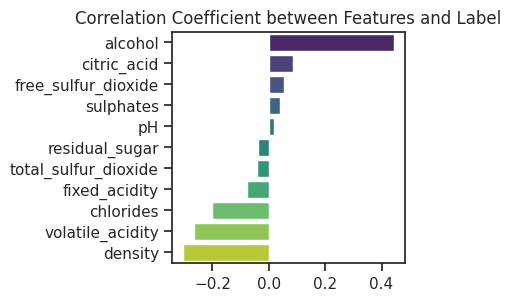

In [ ]:
plt.figure(figsize=(3,3))
data = total_df.corr()["quality"].sort_values(ascending=False)
indices = data.index
labels = []
corr = []
for i in range(1, len(indices)):
    labels.append(indices[i])
    corr.append(data[i])
sns.barplot(x=corr, y=labels, palette='viridis')
plt.title('Correlation Coefficient between Features and Label')
plt.show()

Performing Shapiro-Wilk Test

In [ ]:
for column in total_df.columns[:-1]:
    stat, p = shapiro(total_df[column])
    print(f'Shapiro-Wilk Test for {column}: Statistics={stat}, p-value={p}')

Shapiro-Wilk Test for fixed_acidity: Statistics=0.8797879815101624, p-value=0.0
Shapiro-Wilk Test for volatile_acidity: Statistics=0.875862181186676, p-value=0.0
Shapiro-Wilk Test for citric_acid: Statistics=0.9649786353111267, p-value=5.271599623843331e-37
Shapiro-Wilk Test for residual_sugar: Statistics=0.824682354927063, p-value=0.0
Shapiro-Wilk Test for chlorides: Statistics=0.6183151602745056, p-value=0.0
Shapiro-Wilk Test for free_sulfur_dioxide: Statistics=0.9412973523139954, p-value=5.605193857299268e-45
Shapiro-Wilk Test for total_sulfur_dioxide: Statistics=0.9825838208198547, p-value=1.5920966626574383e-27
Shapiro-Wilk Test for density: Statistics=0.9682108163833618, p-value=1.330269304272158e-35
Shapiro-Wilk Test for pH: Statistics=0.9914482235908508, p-value=2.2076225287757964e-19
Shapiro-Wilk Test for sulphates: Statistics=0.8989558219909668, p-value=0.0
Shapiro-Wilk Test for alcohol: Statistics=0.9535516500473022, p-value=2.9630456028148257e-41
Shapiro-Wilk Test for quali

In [ ]:
def visualize_data_distribution(dataframe, feature, target):

    fig, axes = plt.subplots(1, 3, figsize=(20, 4), constrained_layout=True)
    fig.suptitle(f'Data Distribution for {feature}', fontsize=16)

    sns.kdeplot(data=dataframe, x=feature, ax=axes[0], color='magenta', fill=True)
    axes[0].set_title('Density Plot')

    sns.scatterplot(x=dataframe[feature], y=dataframe[target], ax=axes[1], color='orange')
    axes[1].set_title('Scatter Plot')

    sns.boxplot(y=dataframe[feature], ax=axes[2], color='cyan')
    axes[2].set_title('Box Plot')

    plt.show()

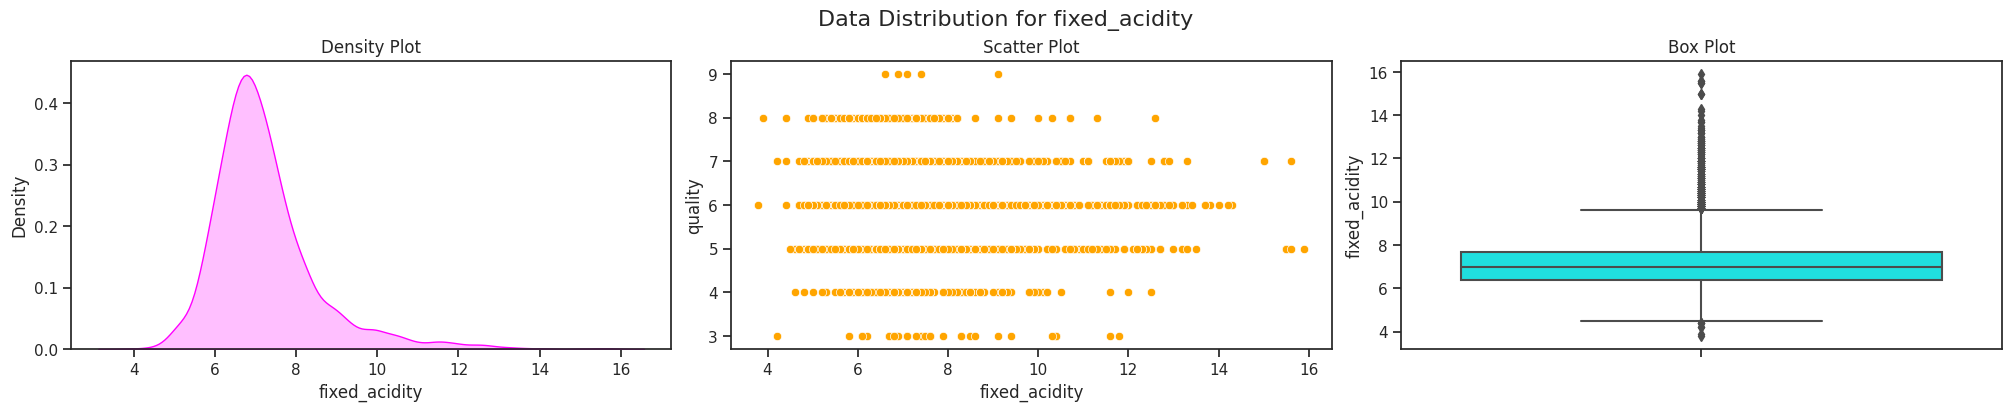

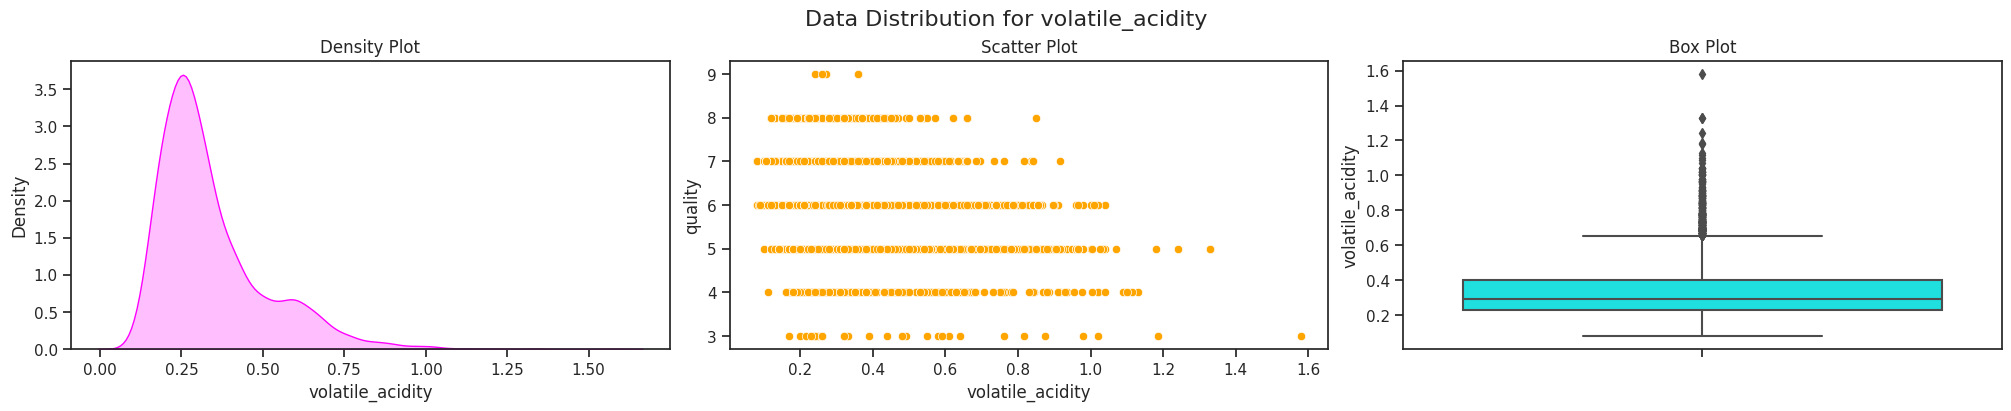

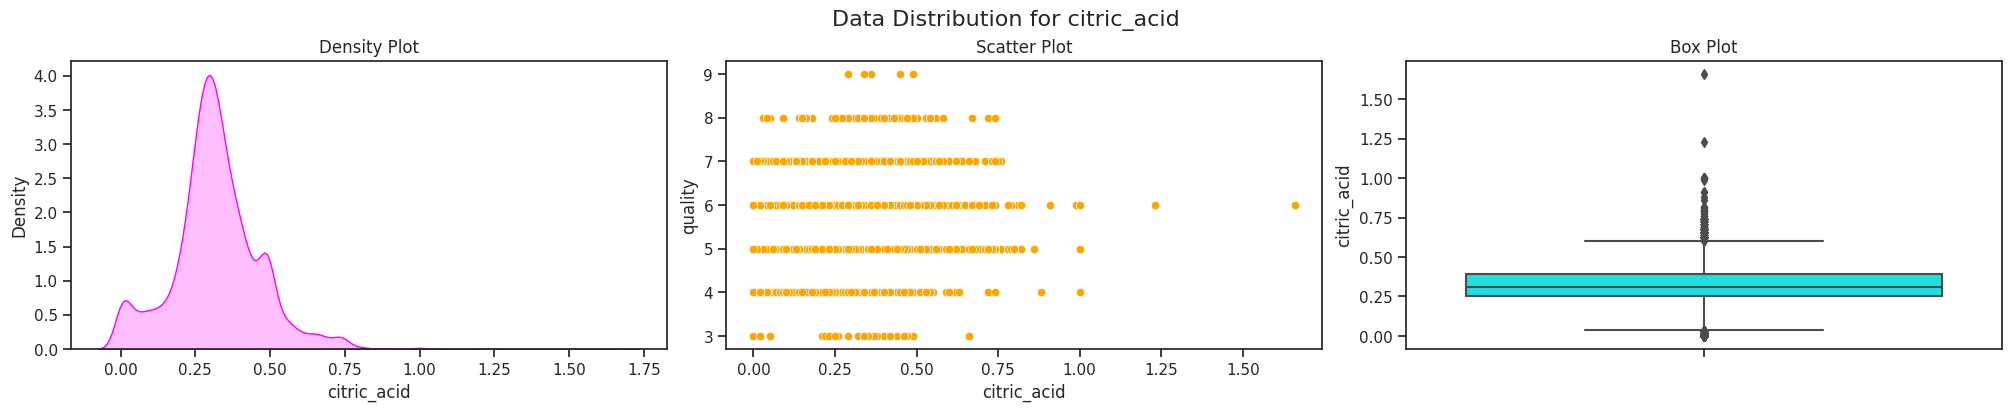

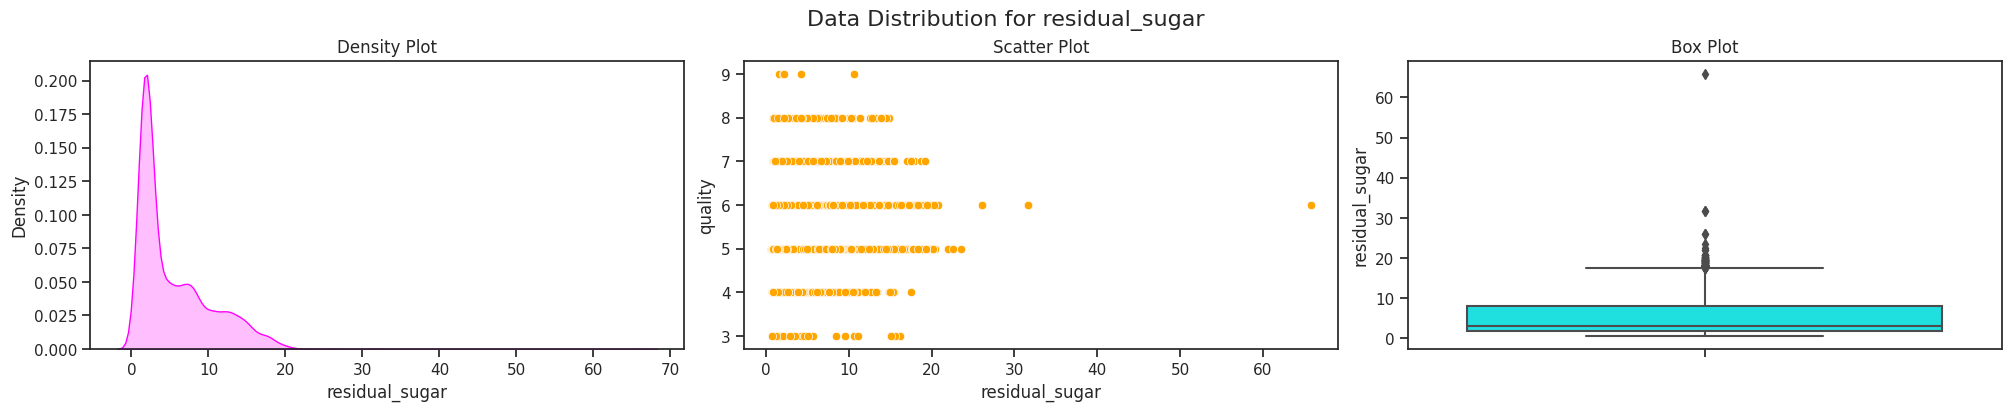

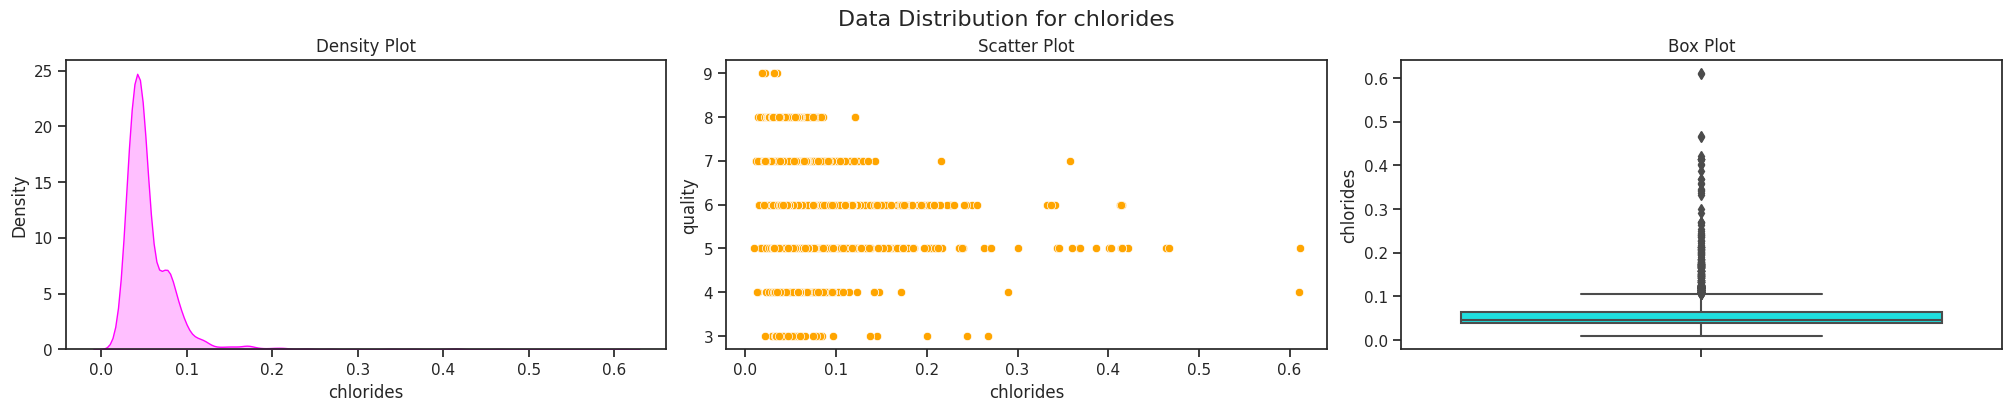

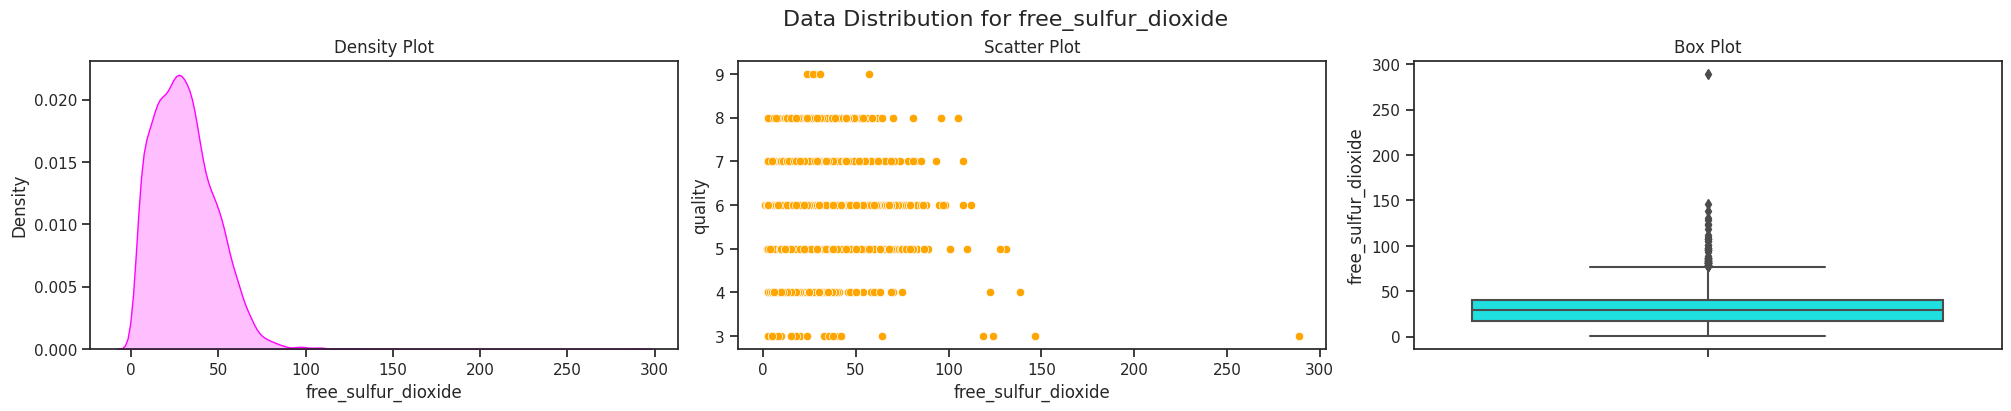

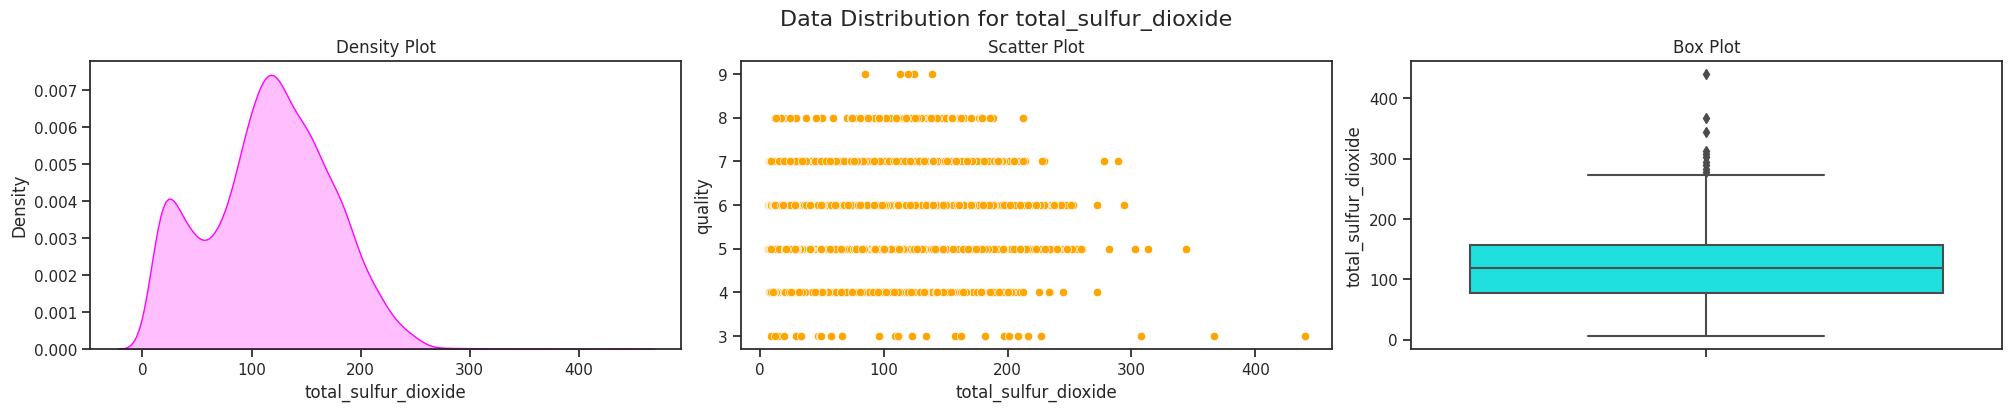

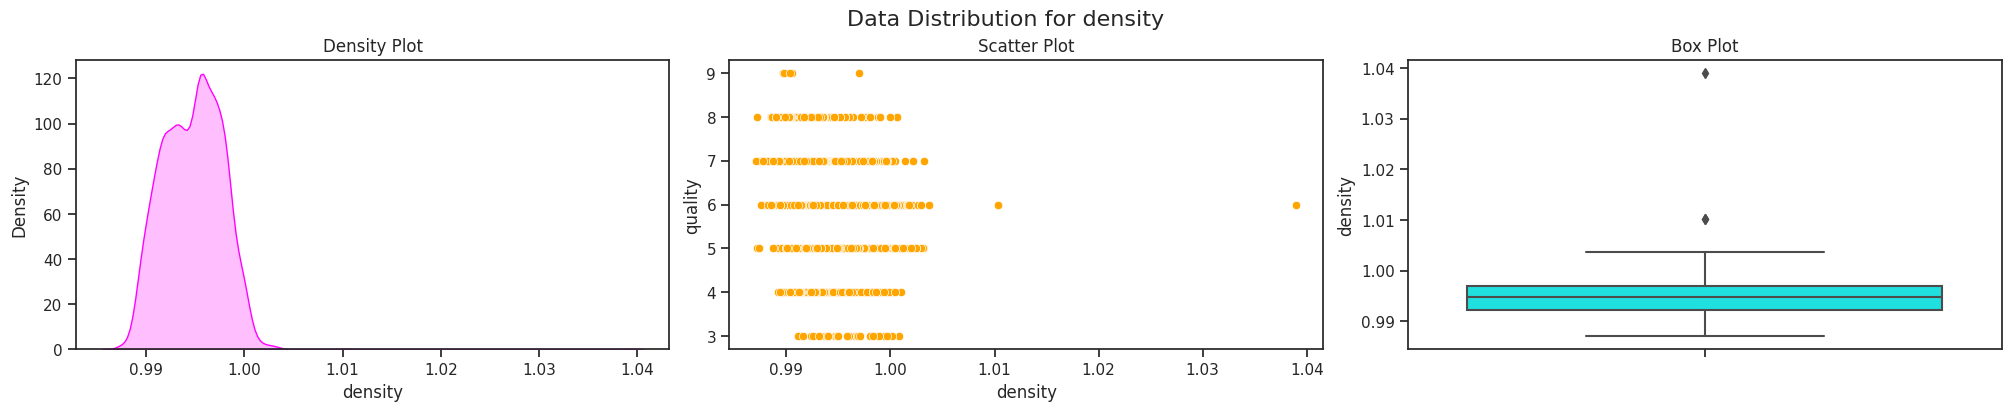

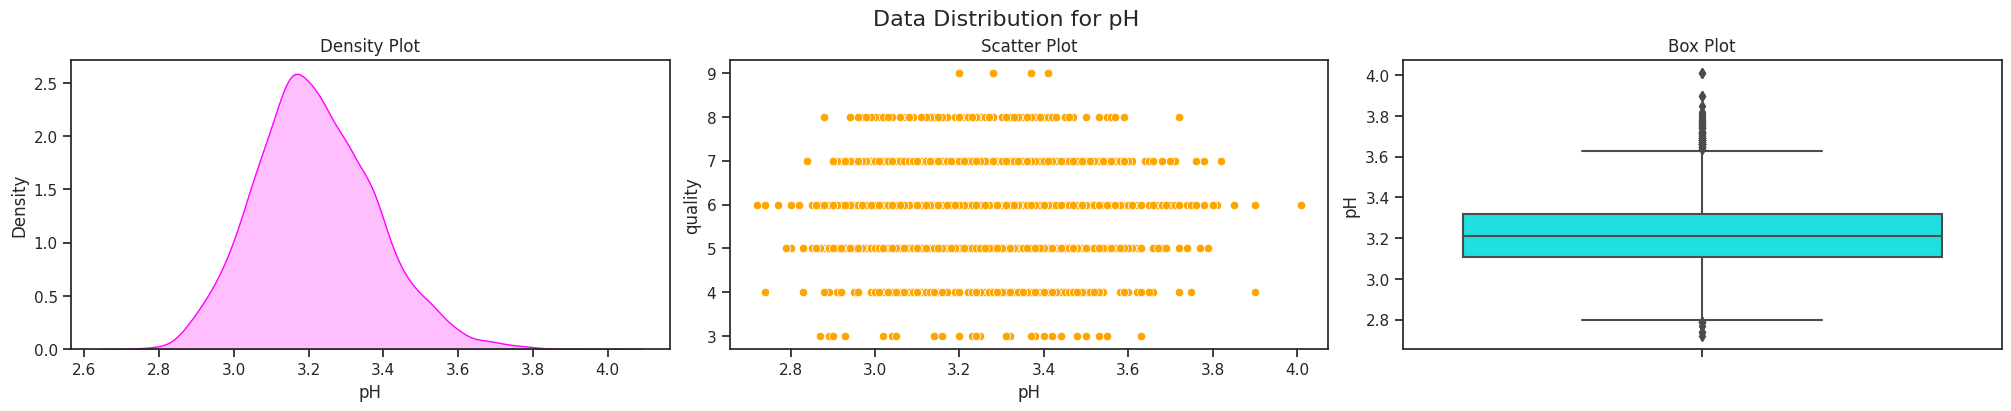

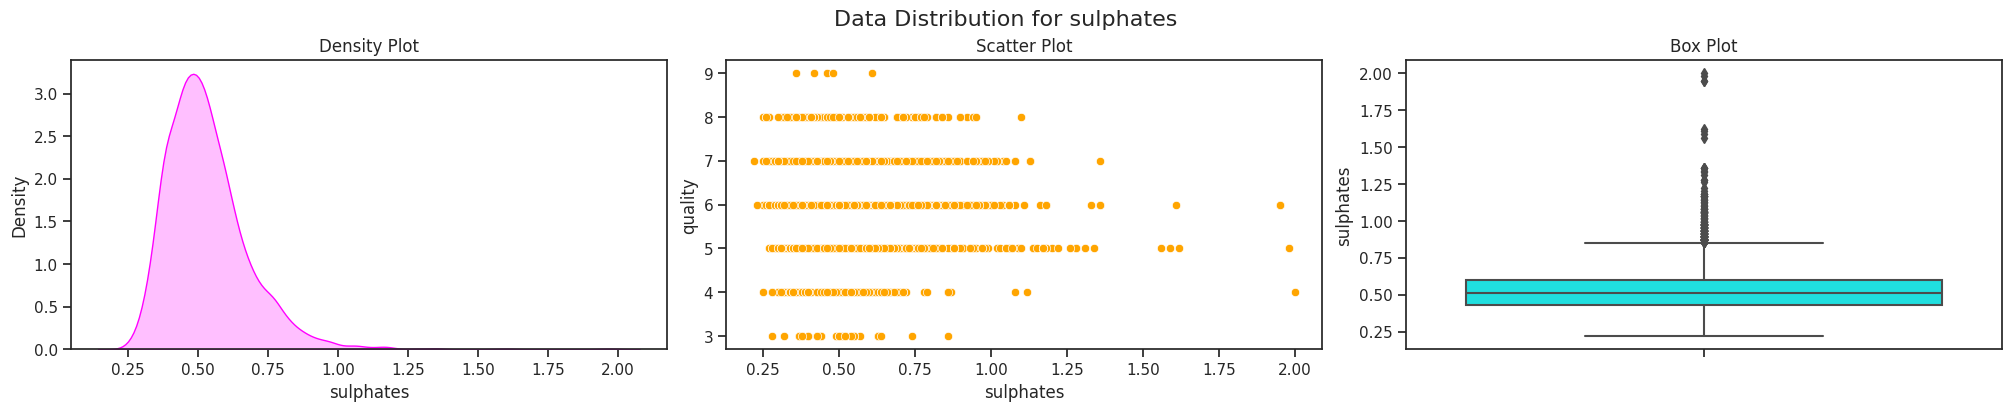

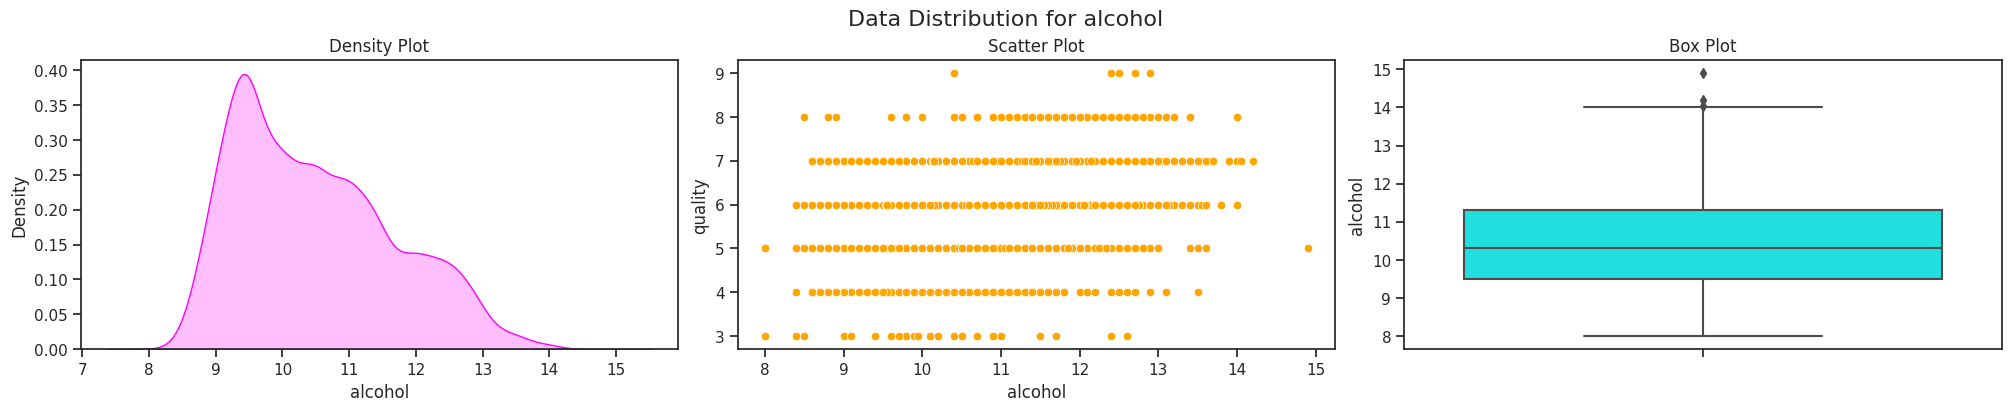

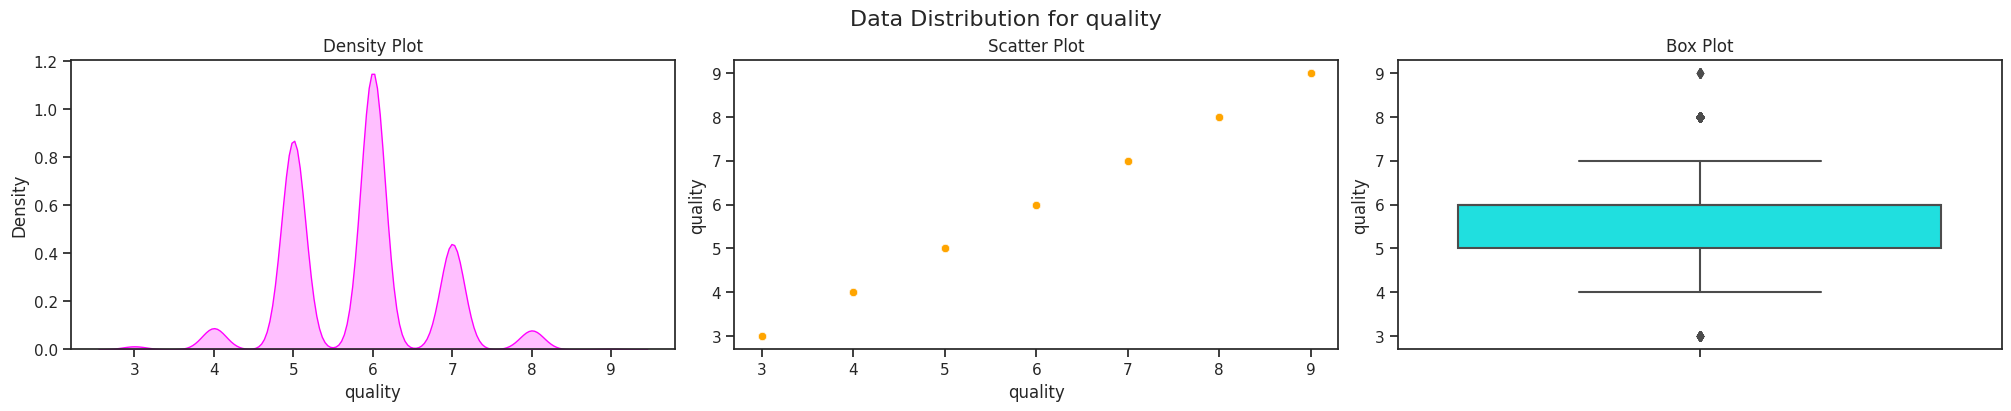

In [ ]:
for feature in total_df.columns:
    if feature != 'color':
        visualize_data_distribution(total_df, feature, 'quality')

Log transformation - reducing skewness of independent variables

In [ ]:
def log_transform(col):
    return np.log(col[0])

total_df['volatile_acidity'] = total_df[['volatile_acidity']].apply(log_transform, axis=1)
total_df['residual_sugar'] = total_df[['residual_sugar']].apply(log_transform, axis=1)
total_df['total_sulfur_dioxide'] = total_df[['total_sulfur_dioxide']].apply(log_transform, axis=1)
total_df['alcohol'] = total_df[['alcohol']].apply(log_transform, axis=1)

Data normalization

In [ ]:
normalized_features = features.copy()
numeric_features = features.dtypes[features.dtypes != "object"].index
normalized_features[numeric_features] = features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
normalized_features[numeric_features].mean(), normalized_features[numeric_features].std()

(fixed_acidity          -4.549573e-16
 volatile_acidity        1.049902e-16
 citric_acid             2.624754e-17
 residual_sugar          5.249508e-17
 chlorides               1.749836e-17
 free_sulfur_dioxide    -1.049902e-16
 total_sulfur_dioxide    0.000000e+00
 density                -3.552167e-15
 pH                      2.729744e-15
 sulphates              -4.899540e-16
 alcohol                 6.561885e-16
 dtype: float64,
 fixed_acidity           1.0
 volatile_acidity        1.0
 citric_acid             1.0
 residual_sugar          1.0
 chlorides               1.0
 free_sulfur_dioxide     1.0
 total_sulfur_dioxide    1.0
 density                 1.0
 pH                      1.0
 sulphates               1.0
 alcohol                 1.0
 dtype: float64)

Correlation Matrix

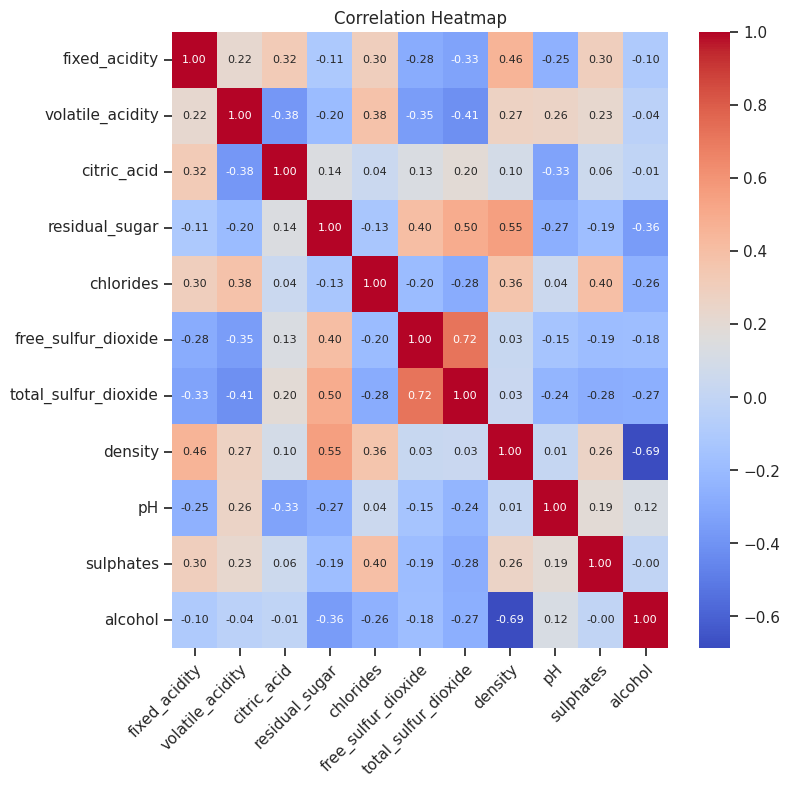

In [ ]:
correlation_matrix = features.corr()
plt.figure(figsize=(8, 8))
ax = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={'size': 8})

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
print(normalized_features.isnull().sum())

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
dtype: int64


**Preparing the data for modeling**

In [ ]:
#splitting data into train&valid and test.
indices_train_valid, indices_test = train_test_split(range(len(normalized_features)), test_size=0.2, random_state=42, shuffle=True)
#splitting train&valid into training and vaildation dataset
indices_train, indices_valid = train_test_split(indices_train_valid, test_size=0.2, random_state=84, shuffle=True)

#association features with marked indices.
train_features = normalized_features.iloc[indices_train]
train_labels = total_df['quality'].iloc[indices_train]
validation_features = normalized_features.iloc[indices_valid]
validation_labels = total_df['quality'].iloc[indices_valid]
test_features = normalized_features.iloc[indices_test]

In [ ]:
print(train_features.shape)
print(train_labels.shape)
if not train_features.shape[0] == train_labels.shape[0]:
  raise AssertionError()

print(validation_features.shape)
print(validation_labels.shape)
if not validation_features.shape[0] == validation_labels.shape[0]:
  raise AssertionError()

(4157, 11)
(4157,)
(1040, 11)
(1040,)


Converting the features and labels into PyTorch tensors

In [ ]:
train_features = torch.tensor(train_features.values.astype(np.float32), dtype=torch.float32)
test_features = torch.tensor(test_features.values.astype(np.float32), dtype=torch.float32)
train_labels = torch.tensor(train_labels.values.reshape(-1,1).astype(np.float32),dtype=torch.float32)
validation_features = torch.tensor(validation_features.values.astype(np.float32), dtype=torch.float32)
validation_labels = torch.tensor(validation_labels.values.astype(np.float32),dtype=torch.float32)

In [ ]:
train_data = TensorDataset(train_features, train_labels)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
valid_data = TensorDataset(validation_features, validation_labels)
valid_loader = DataLoader(valid_data, batch_size=128, shuffle=False)
test_data = TensorDataset(test_features)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

In [ ]:
dataiter = iter(train_loader)
features, labels = next(dataiter)

print('Sample input size: ', features.size()) # batch_size, seq_length
print('Sample input: \n', features)
print()
print('Sample label size: ', labels.size()) # batch_size
print('Sample label: \n', labels)

Sample input size:  torch.Size([128, 11])
Sample input: 
 tensor([[-0.5517, -0.0587, -0.5411,  ..., -0.9858, -1.5542,  0.8453],
        [-0.1661, -0.4839,  1.8674,  ...,  0.7557, -0.8149,  0.5099],
        [-0.3975, -0.5446,  2.8996,  ...,  1.8130, -0.5461, -0.5800],
        ...,
        [ 0.9138, -0.3017,  0.5599,  ...,  1.0666,  0.4619,  0.0069],
        [-0.5517,  0.7309,  0.6287,  ..., -0.2395,  0.3275, -1.2508],
        [-0.1661, -0.7268, -0.0594,  ..., -0.3638, -1.0837,  1.8514]])

Sample label size:  torch.Size([128, 1])
Sample label: 
 tensor([[8.],
        [7.],
        [6.],
        [5.],
        [6.],
        [5.],
        [6.],
        [5.],
        [4.],
        [5.],
        [5.],
        [6.],
        [5.],
        [7.],
        [6.],
        [5.],
        [6.],
        [7.],
        [4.],
        [4.],
        [7.],
        [5.],
        [6.],
        [6.],
        [7.],
        [7.],
        [5.],
        [6.],
        [5.],
        [7.],
        [6.],
        [7.],
  

Linear Regression

In [ ]:
lin_net = nn.Linear(train_features.shape[1], 1)

In [ ]:
lin_net

Linear(in_features=11, out_features=1, bias=True)

In [ ]:
features, labels = next(dataiter)
output=lin_net(features)
output.shape,labels.shape

(torch.Size([128, 1]), torch.Size([128, 1]))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
lin_net = lin_net.to(device)

Establishing the loss function for MLP, in this case Mean Squared Error seems appropriate

In [ ]:
criterion = nn.MSELoss()

In [ ]:
def median_error_rate(output, labels):
    return torch.median(torch.absolute(output/labels-1)).item()

In [ ]:
median_error_rate(output,labels)

0.9593294858932495

Training the model

In [ ]:
def train(model, train_loader, valid_loader, criterion=nn.MSELoss(), num_epochs=200, learning_rate=0.001, weight_decay=0):
    train_losses, valid_losses = [], []
    train_errors, valid_errors = [], []
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    best_loss = float('inf')
    best_epoch = 0
    early_stopping_counter = 0
    for epoch in range(num_epochs):
        tot_train_loss = 0.0
        train_error_rates = torch.tensor([]).to(device)
        train_error_rates_batch = torch.tensor([]).to(device)
        for features, labels in train_loader:
            features = features.to(device)
            labels = labels.to(device)
            output = model(features)
            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tot_train_loss += loss.item()
            train_error_rate_batch = torch.absolute(output.squeeze() / labels.squeeze() - 1)
            train_error_rates_batch = torch.cat((train_error_rates_batch, train_error_rate_batch), dim=0)
            train_error_rate = torch.median(train_error_rates_batch)
            train_error_rates = torch.cat((train_error_rates, train_error_rate.unsqueeze(0)), dim=0)

        else:

            tot_valid_loss = 0.0
            valid_error_rates =torch.tensor([]).to(device)
            valid_error_rates_batch = torch.tensor([]).to(device)
            with torch.no_grad():
                model.eval()
                for features, labels in valid_loader:
                    features = features.to(device)
                    labels = labels.to(device)
                    output = model(features)
                    loss= criterion(output, labels)
                    tot_valid_loss += loss.item()
                    valid_error_rate_batch = torch.absolute(output.squeeze() / labels.squeeze() - 1)
                    valid_error_rates_batch = torch.cat((valid_error_rates_batch, valid_error_rate_batch), dim=0)
                    valid_error_rate = torch.median(valid_error_rates_batch)
                    valid_error_rates = torch.cat((valid_error_rates, valid_error_rate.unsqueeze(0)), dim=0)
        model.train()
        train_loss = tot_train_loss /len(train_loader)
        valid_loss = tot_valid_loss / len(valid_loader)
        train_error = torch.median(train_error_rates).item()
        valid_error = torch.median(valid_error_rates).item()
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_errors.append(train_error)
        valid_errors.append(valid_error)
        if epoch % 10 == 0:
            print("Epoch: {}/{}.. ".format(epoch+1, num_epochs),
              "Train Loss: {:.3f}.. ".format(train_loss),
              "Valid Loss: {:.3f}.. ".format(valid_loss),
              "Train Median Error Rate: {:.3f}.. ".format(train_error),
              "Valid Median Error Rate: {:.3f}.. ".format(valid_error)
              )
    return  train_losses, valid_losses, train_errors, valid_errors

In [ ]:
train_losses, valid_losses, train_errors, valid_errors = train(lin_net, train_loader, valid_loader)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning:

Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning:

Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch: 1/200..  Train Loss: 32.935..  Valid Loss: 32.868..  Train Median Error Rate: 0.973..  Valid Median Error Rate: 0.960.. 
Epoch: 11/200..  Train Loss: 28.402..  Valid Loss: 28.585..  Train Median Error Rate: 0.903..  Valid Median Error Rate: 0.898.. 
Epoch: 21/200..  Train Loss: 25.019..  Valid Loss: 25.300..  Train Median Error Rate: 0.851..  Valid Median Error Rate: 0.846.. 
Epoch: 31/200..  Train Loss: 21.982..  Valid Loss: 22.375..  Train Median Error Rate: 0.797..  Valid Median Error Rate: 0.793.. 
Epoch: 41/200..  Train Loss: 19.272..  Valid Loss: 19.705..  Train Median Error Rate: 0.744..  Valid Median Error Rate: 0.742.. 
Epoch: 51/200..  Train Loss: 16.832..  Valid Loss: 17.273..  Train Median Error Rate: 0.693..  Valid Median Error Rate: 0.692.. 
Epoch: 61/200..  Train Loss: 14.602..  Valid Loss: 15.057..  Train Median Error Rate: 0.643..  Valid Median Error Rate: 0.644.. 
Epoch: 71/200..  Train Loss: 12.576..  Valid Loss: 13.050..  Train Median Error Rate: 0.596..  Val

In [ ]:
def plot_errors(train_errors, valid_errors, num_epochs=200):
    plt.figure(figsize=(10, 7))
    plt.plot(range(1, num_epochs + 1), train_errors, label='Train')
    plt.plot(range(1, num_epochs + 1), valid_errors, label='Valid')
    plt.xlabel('Epoch')
    plt.ylabel('Median Error Rate')
    plt.legend()
    plt.show()

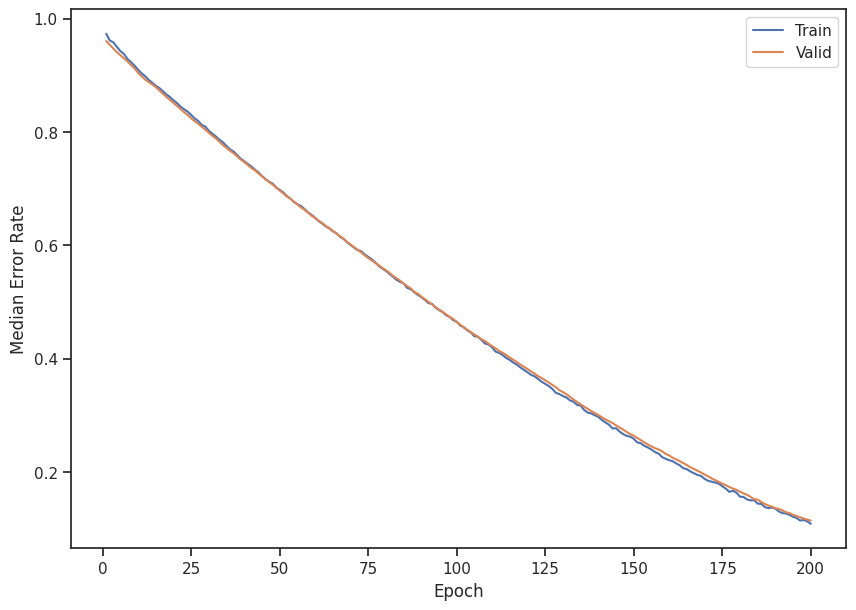

In [ ]:
plot_errors(train_errors, valid_errors)

Building the multi-layer perceptron model: 1 input layer, 1 hidden layer, and 1 output layer

In [ ]:
import torch.nn as nn
model = nn.Sequential(nn.Linear(train_features.shape[1], 256),
                      nn.ReLU(),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Linear(128,1))

In [ ]:
model

Sequential(
  (0): Linear(in_features=11, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
model = model.to(device)

In [ ]:
train_losses, valid_losses,train_errors,valid_errors = train(model, train_loader, valid_loader)

Epoch: 1/200..  Train Loss: 11.366..  Valid Loss: 3.473..  Train Median Error Rate: 0.721..  Valid Median Error Rate: 0.166.. 
Epoch: 11/200..  Train Loss: 0.502..  Valid Loss: 1.040..  Train Median Error Rate: 0.079..  Valid Median Error Rate: 0.074.. 
Epoch: 21/200..  Train Loss: 0.448..  Valid Loss: 1.016..  Train Median Error Rate: 0.075..  Valid Median Error Rate: 0.074.. 
Epoch: 31/200..  Train Loss: 0.440..  Valid Loss: 0.980..  Train Median Error Rate: 0.074..  Valid Median Error Rate: 0.078.. 
Epoch: 41/200..  Train Loss: 0.416..  Valid Loss: 1.029..  Train Median Error Rate: 0.071..  Valid Median Error Rate: 0.077.. 
Epoch: 51/200..  Train Loss: 0.401..  Valid Loss: 1.039..  Train Median Error Rate: 0.072..  Valid Median Error Rate: 0.074.. 
Epoch: 61/200..  Train Loss: 0.389..  Valid Loss: 1.127..  Train Median Error Rate: 0.068..  Valid Median Error Rate: 0.074.. 
Epoch: 71/200..  Train Loss: 0.368..  Valid Loss: 1.106..  Train Median Error Rate: 0.067..  Valid Median Error

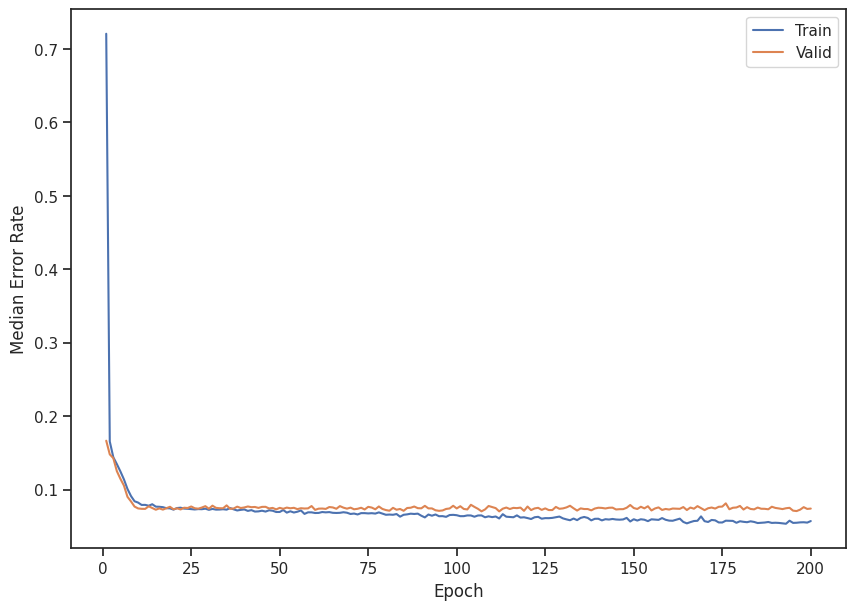

In [ ]:
plot_errors(train_errors, valid_errors)

In [ ]:
import torch.nn.functional as F

In [ ]:
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0):
        super().__init__()
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        self.output = nn.Linear(hidden_layers[-1], output_size)
        self.dropout = nn.Dropout(p=drop_p)

    def forward(self, x):

        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        x = self.output(x)

        return x

In [ ]:
model = Network(train_features.shape[1], 1, [512, 256, 128,64])
model = model.to(device)
train_losses, valid_losses,train_errors,valid_errors = train(model, train_loader, valid_loader)

Epoch: 1/200..  Train Loss: 11.263..  Valid Loss: 3.156..  Train Median Error Rate: 0.732..  Valid Median Error Rate: 0.164.. 
Epoch: 11/200..  Train Loss: 0.479..  Valid Loss: 1.003..  Train Median Error Rate: 0.075..  Valid Median Error Rate: 0.079.. 
Epoch: 21/200..  Train Loss: 0.443..  Valid Loss: 1.011..  Train Median Error Rate: 0.071..  Valid Median Error Rate: 0.075.. 
Epoch: 31/200..  Train Loss: 0.412..  Valid Loss: 1.068..  Train Median Error Rate: 0.069..  Valid Median Error Rate: 0.072.. 
Epoch: 41/200..  Train Loss: 0.379..  Valid Loss: 1.082..  Train Median Error Rate: 0.066..  Valid Median Error Rate: 0.073.. 
Epoch: 51/200..  Train Loss: 0.366..  Valid Loss: 0.986..  Train Median Error Rate: 0.065..  Valid Median Error Rate: 0.077.. 
Epoch: 61/200..  Train Loss: 0.349..  Valid Loss: 1.068..  Train Median Error Rate: 0.064..  Valid Median Error Rate: 0.073.. 
Epoch: 71/200..  Train Loss: 0.301..  Valid Loss: 1.182..  Train Median Error Rate: 0.060..  Valid Median Error

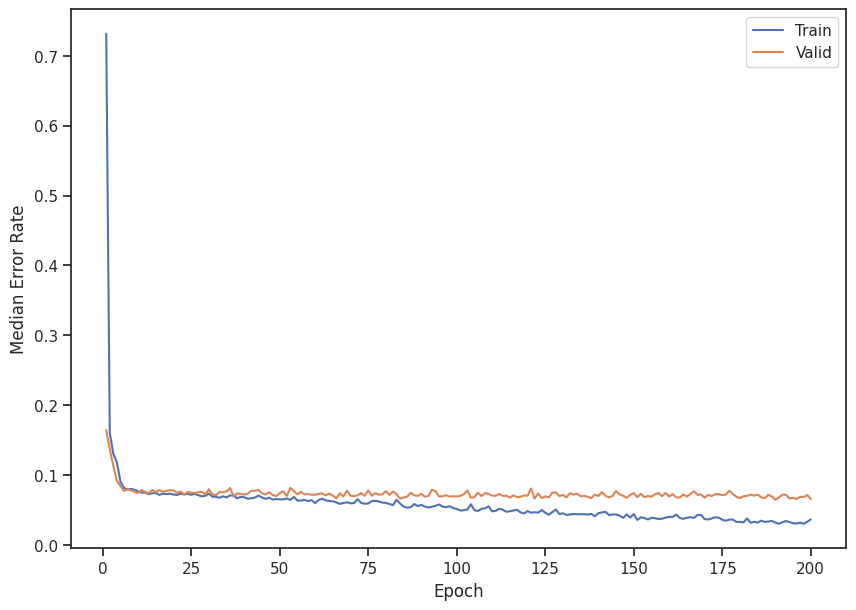

In [ ]:
plot_errors(train_errors, valid_errors)

In [ ]:
model = Network(train_features.shape[1], 1, [512, 256, 128, 64])
model = model.to(device)

In [ ]:
train_losses, valid_losses,train_errors,valid_errors = train(model, train_loader, valid_loader, criterion=nn.L1Loss(), learning_rate=0.001)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning:

Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning:

Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch: 1/200..  Train Loss: 2.734..  Valid Loss: 1.347..  Train Median Error Rate: 0.788..  Valid Median Error Rate: 0.164.. 
Epoch: 11/200..  Train Loss: 0.534..  Valid Loss: 0.799..  Train Median Error Rate: 0.070..  Valid Median Error Rate: 0.073.. 
Epoch: 21/200..  Train Loss: 0.498..  Valid Loss: 0.820..  Train Median Error Rate: 0.066..  Valid Median Error Rate: 0.068.. 
Epoch: 31/200..  Train Loss: 0.473..  Valid Loss: 0.831..  Train Median Error Rate: 0.059..  Valid Median Error Rate: 0.068.. 
Epoch: 41/200..  Train Loss: 0.464..  Valid Loss: 0.804..  Train Median Error Rate: 0.060..  Valid Median Error Rate: 0.073.. 
Epoch: 51/200..  Train Loss: 0.447..  Valid Loss: 0.839..  Train Median Error Rate: 0.058..  Valid Median Error Rate: 0.066.. 
Epoch: 61/200..  Train Loss: 0.412..  Valid Loss: 0.866..  Train Median Error Rate: 0.046..  Valid Median Error Rate: 0.072.. 
Epoch: 71/200..  Train Loss: 0.396..  Valid Loss: 0.854..  Train Median Error Rate: 0.046..  Valid Median Error 

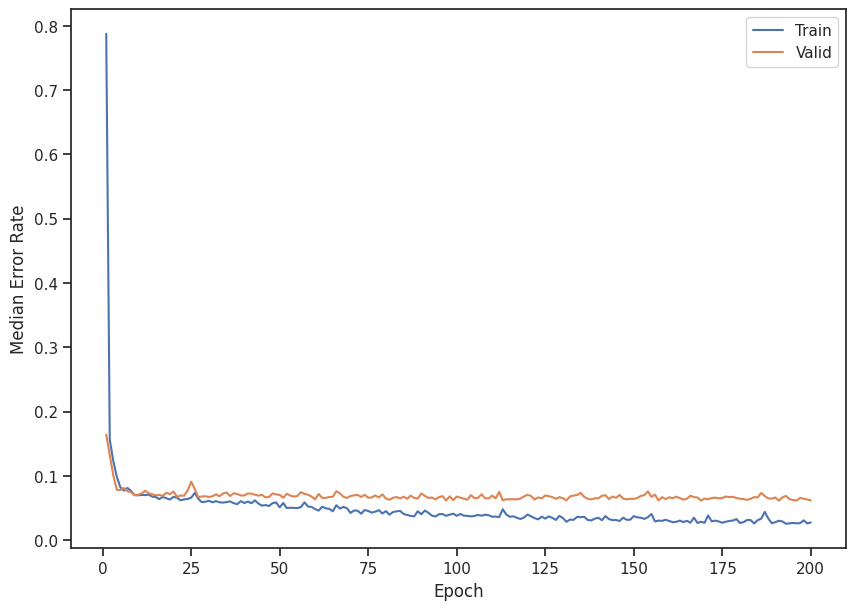

In [ ]:
plot_errors(train_errors, valid_errors)

In [ ]:
model = Network(train_features.shape[1], 1, [512, 256, 128, 64])
model = model.to(device)

In [ ]:
train_losses, valid_losses,train_errors,valid_errors = train(model, train_loader, valid_loader, criterion = nn.L1Loss(),weight_decay=0.0001)

Epoch: 1/200..  Train Loss: 2.609..  Valid Loss: 1.284..  Train Median Error Rate: 0.750..  Valid Median Error Rate: 0.160.. 
Epoch: 11/200..  Train Loss: 0.527..  Valid Loss: 0.775..  Train Median Error Rate: 0.068..  Valid Median Error Rate: 0.073.. 
Epoch: 21/200..  Train Loss: 0.491..  Valid Loss: 0.844..  Train Median Error Rate: 0.065..  Valid Median Error Rate: 0.070.. 
Epoch: 31/200..  Train Loss: 0.478..  Valid Loss: 0.834..  Train Median Error Rate: 0.060..  Valid Median Error Rate: 0.078.. 
Epoch: 41/200..  Train Loss: 0.464..  Valid Loss: 0.800..  Train Median Error Rate: 0.059..  Valid Median Error Rate: 0.072.. 
Epoch: 51/200..  Train Loss: 0.438..  Valid Loss: 0.873..  Train Median Error Rate: 0.052..  Valid Median Error Rate: 0.070.. 
Epoch: 61/200..  Train Loss: 0.423..  Valid Loss: 0.820..  Train Median Error Rate: 0.050..  Valid Median Error Rate: 0.067.. 
Epoch: 71/200..  Train Loss: 0.395..  Valid Loss: 0.833..  Train Median Error Rate: 0.043..  Valid Median Error 

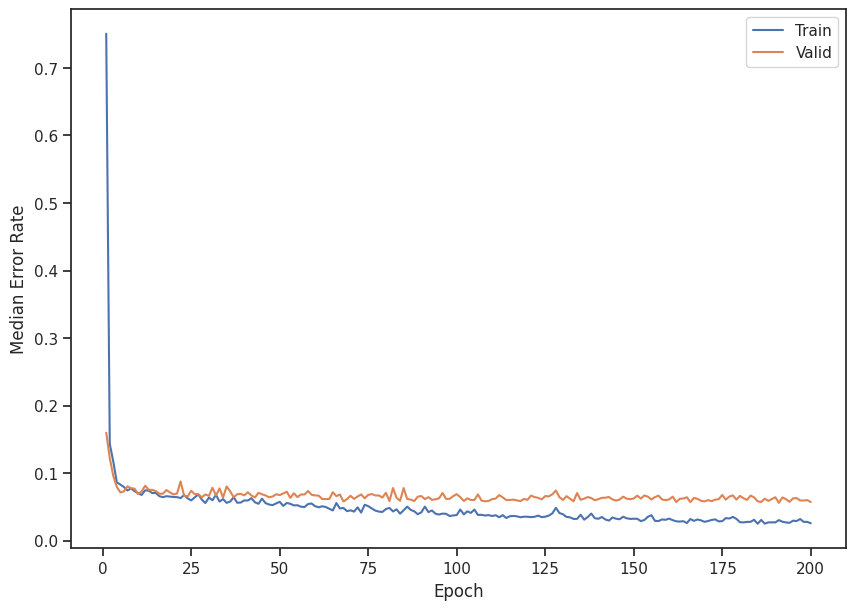

In [ ]:
plot_errors(train_errors, valid_errors)

Adding a dropout layer

In [ ]:
drop_rate=0.05

In [ ]:
model = Network(train_features.shape[1], 1, [512, 256, 128, 64],drop_p=drop_rate)
model = model.to(device)

In [ ]:
train_losses, valid_losses,train_errors,valid_errors = train(model, train_loader, valid_loader, criterion = nn.L1Loss(),weight_decay=0.0001)

Epoch: 1/200..  Train Loss: 2.592..  Valid Loss: 1.229..  Train Median Error Rate: 0.749..  Valid Median Error Rate: 0.152.. 
Epoch: 11/200..  Train Loss: 0.665..  Valid Loss: 0.788..  Train Median Error Rate: 0.094..  Valid Median Error Rate: 0.074.. 
Epoch: 21/200..  Train Loss: 0.620..  Valid Loss: 0.802..  Train Median Error Rate: 0.088..  Valid Median Error Rate: 0.074.. 
Epoch: 31/200..  Train Loss: 0.587..  Valid Loss: 0.797..  Train Median Error Rate: 0.084..  Valid Median Error Rate: 0.076.. 
Epoch: 41/200..  Train Loss: 0.579..  Valid Loss: 0.818..  Train Median Error Rate: 0.081..  Valid Median Error Rate: 0.073.. 
Epoch: 51/200..  Train Loss: 0.570..  Valid Loss: 0.859..  Train Median Error Rate: 0.078..  Valid Median Error Rate: 0.068.. 
Epoch: 61/200..  Train Loss: 0.563..  Valid Loss: 0.814..  Train Median Error Rate: 0.082..  Valid Median Error Rate: 0.070.. 
Epoch: 71/200..  Train Loss: 0.548..  Valid Loss: 0.856..  Train Median Error Rate: 0.079..  Valid Median Error 

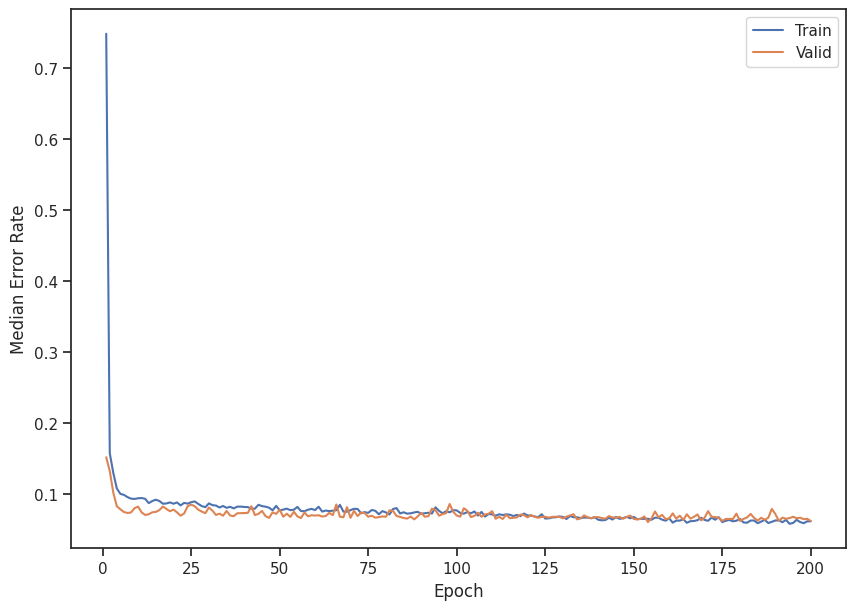

In [ ]:
plot_errors(train_errors, valid_errors)

In [ ]:
checkpoint = {'input_size': train_features.shape[1],
              'output_size': 1,
              'hidden_layers': [each.out_features for each in model.hidden_layers],
              'drop_p': drop_rate,
              'state_dict': model.state_dict()}
torch.save(checkpoint, 'checkpoint.pth')

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = Network(checkpoint['input_size'],
                             checkpoint['output_size'],
                             checkpoint['hidden_layers'],
                               checkpoint['drop_p'])
    model.load_state_dict(checkpoint['state_dict'])
    return model

In [ ]:
model = load_checkpoint('checkpoint.pth')
print(model)

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=11, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.05, inplace=False)
)


Testing on our real data

In [ ]:
model = model.to(device)
model.eval()
dataiter = iter(test_loader)
features, = next(dataiter)
features=features.to(device)
output = model(features)

In [ ]:
features.shape, output.shape

(torch.Size([128, 11]), torch.Size([128, 1]))

In [ ]:
def test(model, test_loader):
    model.eval()
    pred_labels = torch.tensor([]).to(device)
    with torch.no_grad():
      for features, in test_loader:
            features = features.to(device)
            output = model(features)
            pred_labels = torch.cat( (pred_labels,output),dim=0)
    return  pred_labels

In [ ]:
pred_labels =test(model,test_loader)

In [ ]:
pred_labels.shape

torch.Size([1300, 1])

In [ ]:
pred_labels=torch.round(pred_labels, decimals=2)

In [ ]:
pred_labels[:20]

tensor([[6.1900],
        [4.9000],
        [7.0500],
        [5.3000],
        [5.3100],
        [6.4000],
        [5.1500],
        [6.2000],
        [4.9300],
        [6.6500],
        [5.3400],
        [5.1800],
        [6.2400],
        [4.9600],
        [5.7700],
        [5.3300],
        [4.9500],
        [5.7600],
        [6.0600],
        [5.1200]], device='cuda:0')

In [ ]:
test_labels = total_df['quality'].iloc[indices_test]

In [ ]:
test_labels.shape

(1300,)

In [ ]:
test_errors=pred_labels.cpu().numpy().squeeze()/test_labels-1
test_errors.shape

(1300,)

In [ ]:
median_test_error=np.median(np.absolute(test_errors)).item()

In [ ]:
median_test_error

0.06800003051757808

Predicting wine quality using 1-D CNN

In [ ]:
num_features = 11
class WineQualityNet(nn.Module):
    def __init__(self, num_features):
        super(WineQualityNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(64 * num_features, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)

        return x

In [ ]:
model = WineQualityNet(num_features=train_features.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 30
valid_loss_min = np.Inf

for epoch in range(1, epochs+1):
    train_loss = 0.0
    valid_loss = 0.0

    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    model.eval()
    for data, target in valid_loader:
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)

    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model_wine_quality.pt')
        valid_loss_min = valid_loss

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning:

Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning:

Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch: 1 	Training Loss: 2.075168 	Validation Loss: 0.941764
Validation loss decreased (inf --> 0.941764).  Saving model ...
Epoch: 2 	Training Loss: 2.367159 	Validation Loss: 1.067880
Epoch: 3 	Training Loss: 2.025722 	Validation Loss: 1.426374
Epoch: 4 	Training Loss: 1.955966 	Validation Loss: 1.272666
Epoch: 5 	Training Loss: 1.898843 	Validation Loss: 1.552355
Epoch: 6 	Training Loss: 1.886376 	Validation Loss: 0.989494
Epoch: 7 	Training Loss: 1.820009 	Validation Loss: 1.435933
Epoch: 8 	Training Loss: 1.823536 	Validation Loss: 1.025005
Epoch: 9 	Training Loss: 1.694894 	Validation Loss: 1.027911
Epoch: 10 	Training Loss: 1.740432 	Validation Loss: 1.122974
Epoch: 11 	Training Loss: 1.665096 	Validation Loss: 1.061529
Epoch: 12 	Training Loss: 1.656560 	Validation Loss: 1.226218
Epoch: 13 	Training Loss: 1.662185 	Validation Loss: 1.237917
Epoch: 14 	Training Loss: 1.650946 	Validation Loss: 1.081256
Epoch: 15 	Training Loss: 1.680419 	Validation Loss: 1.022276
Epoch: 16 	Trai

In [ ]:
model.load_state_dict(torch.load('model_wine_quality.pt'))

<All keys matched successfully>

In [ ]:
test_labels = total_df['quality'].iloc[indices_test]


test_features = torch.tensor(normalized_features.iloc[indices_test].values.astype(np.float32), dtype=torch.float32)
test_labels = torch.tensor(test_labels.values.reshape(-1, 1).astype(np.float32), dtype=torch.float32)

test_data = TensorDataset(test_features, test_labels)

test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

test_loss = 0.0
size = len(test_loader.dataset)
predictions = np.zeros(size)
targets = np.zeros(size)
idx = 0

model.eval()

for data, target in test_loader:
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item() * data.size(0)

    predictions[idx:idx + len(target)] = output.detach().cpu().numpy().flatten()
    targets[idx:idx + len(target)] = target.cpu().numpy().flatten()
    idx += len(target)

test_loss = test_loss / size
print('Test Loss: {:.6f}\n'.format(test_loss))

from sklearn.metrics import median_absolute_error
median_error = median_absolute_error(targets, predictions)
print('Median Absolute Error: {:.6f}'.format(median_error))

Test Loss: 0.556135

Median Absolute Error: 0.465697


Using other models for comparisons

*   Random Forest
*   Logistic Regression Model (Base model)

In [ ]:
model = RandomForestRegressor(random_state=0)
model.fit(train_features, train_labels)
predicted_test_labels = model.predict(test_features)
test_labels = total_df['quality'].iloc[indices_test]
median_error = median_absolute_error(test_labels, predicted_test_labels)
rmse = mean_squared_error(test_labels, predicted_test_labels, squared=False)


print("Median Absolute Error: ", median_error)
print("Root Mean Squared Error: ", rmse)

<ipython-input-122-dd314f845283>:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Median Absolute Error:  0.3099999999999996
Root Mean Squared Error:  0.6250049230575339


In [ ]:
test_labels = total_df['quality'].iloc[indices_test]
threshold = 6
train_labels_binary = np.where(train_labels >= threshold, 1, 0)
test_labels_binary = np.where(test_labels >= threshold, 1, 0)

logit_model = LogisticRegression()
logit_model.fit(train_features, train_labels_binary)
predicted_test_labels = logit_model.predict(test_features)
predicted_probabilities = logit_model.predict_proba(test_features)[:, 1]

accuracy = accuracy_score(test_labels_binary, predicted_test_labels)
f1 = f1_score(test_labels_binary, predicted_test_labels)
precision = precision_score(test_labels_binary, predicted_test_labels)
recall = recall_score(test_labels_binary, predicted_test_labels)
roc_auc = roc_auc_score(test_labels_binary, predicted_probabilities)
median_error = median_absolute_error(test_labels_binary, predicted_probabilities)

print("Accuracy: ", accuracy)
print("F1 Score: ", f1)
print("Precision: ", precision)
print("Recall: ", recall)
print("ROC AUC Score: ", roc_auc)
print("Median Absolute Error: ", median_error)

Accuracy:  0.7238461538461538
F1 Score:  0.7899356348741955
Precision:  0.7848837209302325
Recall:  0.7950530035335689
ROC AUC Score:  0.7769568476282257
Median Absolute Error:  0.2913368771501344


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [ ]:
def mer_eval(y_pred, y_true):
    y_true = y_true.get_label()
    mer = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return 'mer', mer

dtrain = xgb.DMatrix(train_features, label=train_labels)
dvalid = xgb.DMatrix(validation_features, label=validation_labels)
dtest = xgb.DMatrix(test_features)

params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'reg:squarederror',
}

num_round = 100
evallist = [(dvalid, 'eval'), (dtrain, 'train')]
bst = xgb.train(params, dtrain, num_round, evallist, feval=mer_eval)

test_predictions = bst.predict(dtest)

[0]	eval-rmse:0.83392	eval-mer:11.58455	train-rmse:0.85806	train-mer:12.13852
[1]	eval-rmse:0.81323	eval-mer:11.24709	train-rmse:0.83823	train-mer:11.79951
[2]	eval-rmse:0.79664	eval-mer:10.97359	train-rmse:0.82179	train-mer:11.53300
[3]	eval-rmse:0.78199	eval-mer:10.76916	train-rmse:0.80747	train-mer:11.32798
[4]	eval-rmse:0.77032	eval-mer:10.58930	train-rmse:0.79540	train-mer:11.14270
[5]	eval-rmse:0.76037	eval-mer:10.45426	train-rmse:0.78519	train-mer:11.00528
[6]	eval-rmse:0.75145	eval-mer:10.33995	train-rmse:0.77646	train-mer:10.89251
[7]	eval-rmse:0.74319	eval-mer:10.22882	train-rmse:0.76869	train-mer:10.79361
[8]	eval-rmse:0.73683	eval-mer:10.16868	train-rmse:0.76216	train-mer:10.72324
[9]	eval-rmse:0.73122	eval-mer:10.10065	train-rmse:0.75576	train-mer:10.64662
[10]	eval-rmse:0.72570	eval-mer:10.03380	train-rmse:0.74967	train-mer:10.56235
[11]	eval-rmse:0.72121	eval-mer:9.96691	train-rmse:0.74496	train-mer:10.49453
[12]	eval-rmse:0.71801	eval-mer:9.90984	train-rmse:0.74104	trai

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:726: FutureWarning:

Pass `evals` as keyword args.

/usr/local/lib/python3.10/dist-packages/xgboost/training.py:38: UserWarning:

`feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.



[47]	eval-rmse:0.67385	eval-mer:9.20271	train-rmse:0.67612	train-mer:9.42344
[48]	eval-rmse:0.67345	eval-mer:9.19952	train-rmse:0.67576	train-mer:9.41880
[49]	eval-rmse:0.67212	eval-mer:9.17974	train-rmse:0.67421	train-mer:9.39404
[50]	eval-rmse:0.67165	eval-mer:9.17874	train-rmse:0.67301	train-mer:9.37520
[51]	eval-rmse:0.67132	eval-mer:9.16680	train-rmse:0.67199	train-mer:9.35647
[52]	eval-rmse:0.67147	eval-mer:9.16659	train-rmse:0.67106	train-mer:9.34607
[53]	eval-rmse:0.67052	eval-mer:9.15865	train-rmse:0.66965	train-mer:9.32773
[54]	eval-rmse:0.67078	eval-mer:9.16212	train-rmse:0.66928	train-mer:9.32270
[55]	eval-rmse:0.67058	eval-mer:9.16087	train-rmse:0.66896	train-mer:9.31927
[56]	eval-rmse:0.67020	eval-mer:9.15751	train-rmse:0.66826	train-mer:9.30798
[57]	eval-rmse:0.67020	eval-mer:9.15436	train-rmse:0.66696	train-mer:9.28895
[58]	eval-rmse:0.66915	eval-mer:9.14000	train-rmse:0.66541	train-mer:9.26534
[59]	eval-rmse:0.66848	eval-mer:9.13063	train-rmse:0.66440	train-mer:9.25033